In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import json
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Configuration

In [2]:
# Paths
DATASET_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\dataset')
PREP_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\model_results\preprocessing')
MODEL1_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\model_results\model1_resnet18')
MODEL2_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\model_results\model2_vgg16')
FUSION_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\model_results\fusion_model')
FUSION_PATH.mkdir(parents=True, exist_ok=True)

# Load preprocessing config
with open(PREP_PATH / 'config.json', 'r') as f:
    config = json.load(f)

BLOOD_GROUPS = config['classes']
NUM_CLASSES = config['num_classes']
IMAGE_SIZE = config['image_size']
BATCH_SIZE = 64  # Larger batch size for inference

print(f"Classes: {NUM_CLASSES}")
print(f"Blood Groups: {BLOOD_GROUPS}")
print(f"Image size: {IMAGE_SIZE}")

Classes: 8
Blood Groups: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
Image size: 224


## Load Individual Model Results

In [3]:
# Load Model 1 (ResNet-18) results
with open(MODEL1_PATH / 'results.json', 'r') as f:
    model1_results = json.load(f)

# Load Model 2 (VGG-16) results
with open(MODEL2_PATH / 'results.json', 'r') as f:
    model2_results = json.load(f)

print("Individual Model Performance:")
print("="*60)
print(f"ResNet-18  - Test Accuracy: {model1_results['test_acc']:.2f}%")
print(f"VGG-16     - Test Accuracy: {model2_results['test_acc']:.2f}%")
print("="*60)

Individual Model Performance:
ResNet-18  - Test Accuracy: 91.22%
VGG-16     - Test Accuracy: 81.89%


## Load Data

In [4]:
# Load test split
test_df = pd.read_csv(PREP_PATH / 'test_split.csv')
print(f"Test samples: {len(test_df)}")

Test samples: 900


## Dataset & DataLoader

In [5]:
class BloodDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = Image.open(self.df.iloc[idx]['path']).convert('RGB')
        label = self.df.iloc[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = BloodDataset(test_df, test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Test batches: {len(test_loader)}")

Test batches: 15


## Load Pre-trained Models

In [6]:
# Load ResNet-18
model1 = models.resnet18(pretrained=False)
model1.fc = nn.Linear(model1.fc.in_features, NUM_CLASSES)
model1.load_state_dict(torch.load(MODEL1_PATH / 'best_model.pth'))
model1 = model1.to(device)
model1.eval()

# Load VGG-16
model2 = models.vgg16(pretrained=False)
model2.classifier[6] = nn.Linear(model2.classifier[6].in_features, NUM_CLASSES)
model2.load_state_dict(torch.load(MODEL2_PATH / 'best_model.pth'))
model2 = model2.to(device)
model2.eval()

print("✓ ResNet-18 loaded")
print("✓ VGG-16 loaded")
print("\nBoth models ready for fusion!")

✓ ResNet-18 loaded
✓ VGG-16 loaded

Both models ready for fusion!


## Fusion Strategy 1: Average Predictions (Soft Voting)

In [7]:
def fusion_average(model1, model2, loader, device):
    """
    Soft voting: Average the probability outputs from both models
    """
    all_preds = []
    all_labels = []
    all_probs_model1 = []
    all_probs_model2 = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Fusion (Average)'):
            images = images.to(device)
            
            # Get predictions from both models
            outputs1 = model1(images)
            outputs2 = model2(images)
            
            # Convert to probabilities
            probs1 = F.softmax(outputs1, dim=1)
            probs2 = F.softmax(outputs2, dim=1)
            
            # Average probabilities
            avg_probs = (probs1 + probs2) / 2
            
            # Final prediction
            _, predicted = avg_probs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs_model1.append(probs1.cpu().numpy())
            all_probs_model2.append(probs2.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), all_probs_model1, all_probs_model2

print("Fusion function defined: Average Predictions")

Fusion function defined: Average Predictions


## Fusion Strategy 2: Weighted Average

In [8]:
def fusion_weighted(model1, model2, loader, device, weight1=0.5, weight2=0.5):
    """
    Weighted voting: Weighted average based on individual model performance
    """
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Fusion (Weighted)'):
            images = images.to(device)
            
            # Get predictions from both models
            outputs1 = model1(images)
            outputs2 = model2(images)
            
            # Convert to probabilities
            probs1 = F.softmax(outputs1, dim=1)
            probs2 = F.softmax(outputs2, dim=1)
            
            # Weighted average
            weighted_probs = weight1 * probs1 + weight2 * probs2
            
            # Final prediction
            _, predicted = weighted_probs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

print("Fusion function defined: Weighted Average")

Fusion function defined: Weighted Average


## Fusion Strategy 3: Max Voting (Hard Voting)

In [9]:
def fusion_max_voting(model1, model2, loader, device):
    """
    Hard voting: Each model votes, take the class with max votes
    """
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Fusion (Max Voting)'):
            images = images.to(device)
            
            # Get predictions from both models
            outputs1 = model1(images)
            outputs2 = model2(images)
            
            # Get class predictions
            _, pred1 = outputs1.max(1)
            _, pred2 = outputs2.max(1)
            
            # Convert to numpy for voting
            pred1_np = pred1.cpu().numpy()
            pred2_np = pred2.cpu().numpy()
            
            # Majority voting (if tie, use model1's prediction)
            final_preds = []
            for p1, p2 in zip(pred1_np, pred2_np):
                if p1 == p2:
                    final_preds.append(p1)
                else:
                    # Tie-breaker: use ResNet's prediction (it has higher accuracy)
                    final_preds.append(p1)
            
            all_preds.extend(final_preds)
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

print("Fusion function defined: Max Voting")

Fusion function defined: Max Voting


## Evaluate Fusion Strategy 1: Average Predictions

In [10]:
print("\n" + "="*60)
print("FUSION STRATEGY 1: AVERAGE PREDICTIONS (SOFT VOTING)")
print("="*60)

fusion_preds, fusion_labels, probs1, probs2 = fusion_average(model1, model2, test_loader, device)
fusion_avg_acc = accuracy_score(fusion_labels, fusion_preds)

print(f"\nFusion Accuracy (Average): {fusion_avg_acc*100:.2f}%")
print(f"Improvement over ResNet-18: {(fusion_avg_acc*100 - model1_results['test_acc']):.2f}%")
print(f"Improvement over VGG-16: {(fusion_avg_acc*100 - model2_results['test_acc']):.2f}%")

print("\nClassification Report (Average Fusion):")
print(classification_report(fusion_labels, fusion_preds, target_names=BLOOD_GROUPS))


FUSION STRATEGY 1: AVERAGE PREDICTIONS (SOFT VOTING)


Fusion (Average): 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


Fusion Accuracy (Average): 89.89%
Improvement over ResNet-18: -1.33%
Improvement over VGG-16: 8.00%

Classification Report (Average Fusion):
              precision    recall  f1-score   support

          A+       0.88      0.93      0.90        85
          A-       0.90      0.91      0.90       151
         AB+       0.92      0.92      0.92       106
         AB-       0.91      0.89      0.90       114
          B+       0.91      0.88      0.89        98
          B-       0.91      0.95      0.93       111
          O+       0.88      0.91      0.90       128
          O-       0.90      0.81      0.85       107

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



## Evaluate Fusion Strategy 2: Weighted Average

In [11]:
print("\n" + "="*60)
print("FUSION STRATEGY 2: WEIGHTED AVERAGE")
print("="*60)

# Calculate weights based on individual model accuracies
model1_acc = model1_results['test_acc']
model2_acc = model2_results['test_acc']
total_acc = model1_acc + model2_acc

weight1 = model1_acc / total_acc
weight2 = model2_acc / total_acc

print(f"\nWeights based on individual accuracies:")
print(f"ResNet-18 weight: {weight1:.3f}")
print(f"VGG-16 weight: {weight2:.3f}")

fusion_preds_w, fusion_labels_w = fusion_weighted(model1, model2, test_loader, device, weight1, weight2)
fusion_weighted_acc = accuracy_score(fusion_labels_w, fusion_preds_w)

print(f"\nFusion Accuracy (Weighted): {fusion_weighted_acc*100:.2f}%")
print(f"Improvement over ResNet-18: {(fusion_weighted_acc*100 - model1_results['test_acc']):.2f}%")
print(f"Improvement over VGG-16: {(fusion_weighted_acc*100 - model2_results['test_acc']):.2f}%")

print("\nClassification Report (Weighted Fusion):")
print(classification_report(fusion_labels_w, fusion_preds_w, target_names=BLOOD_GROUPS))


FUSION STRATEGY 2: WEIGHTED AVERAGE

Weights based on individual accuracies:
ResNet-18 weight: 0.527
VGG-16 weight: 0.473


Fusion (Weighted): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Fusion Accuracy (Weighted): 90.56%
Improvement over ResNet-18: -0.67%
Improvement over VGG-16: 8.67%

Classification Report (Weighted Fusion):
              precision    recall  f1-score   support

          A+       0.88      0.93      0.90        85
          A-       0.91      0.90      0.91       151
         AB+       0.92      0.92      0.92       106
         AB-       0.93      0.89      0.91       114
          B+       0.91      0.88      0.90        98
          B-       0.91      0.95      0.93       111
          O+       0.88      0.94      0.91       128
          O-       0.90      0.82      0.86       107

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.90       900
weighted avg       0.91      0.91      0.91       900



## Evaluate Fusion Strategy 3: Max Voting

In [12]:
print("\n" + "="*60)
print("FUSION STRATEGY 3: MAX VOTING (HARD VOTING)")
print("="*60)

fusion_preds_mv, fusion_labels_mv = fusion_max_voting(model1, model2, test_loader, device)
fusion_maxvote_acc = accuracy_score(fusion_labels_mv, fusion_preds_mv)

print(f"\nFusion Accuracy (Max Voting): {fusion_maxvote_acc*100:.2f}%")
print(f"Improvement over ResNet-18: {(fusion_maxvote_acc*100 - model1_results['test_acc']):.2f}%")
print(f"Improvement over VGG-16: {(fusion_maxvote_acc*100 - model2_results['test_acc']):.2f}%")

print("\nClassification Report (Max Voting Fusion):")
print(classification_report(fusion_labels_mv, fusion_preds_mv, target_names=BLOOD_GROUPS))


FUSION STRATEGY 3: MAX VOTING (HARD VOTING)


Fusion (Max Voting): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Fusion Accuracy (Max Voting): 91.22%
Improvement over ResNet-18: 0.00%
Improvement over VGG-16: 9.33%

Classification Report (Max Voting Fusion):
              precision    recall  f1-score   support

          A+       0.87      0.95      0.91        85
          A-       0.91      0.93      0.92       151
         AB+       0.87      0.92      0.89       106
         AB-       0.96      0.91      0.94       114
          B+       0.93      0.89      0.91        98
          B-       0.96      0.95      0.96       111
          O+       0.89      0.97      0.93       128
          O-       0.91      0.76      0.83       107

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900



## Compare All Strategies

In [13]:
# Summary comparison
results_comparison = pd.DataFrame({
    'Model': [
        'ResNet-18 (Alone)',
        'VGG-16 (Alone)',
        'Fusion: Average',
        'Fusion: Weighted',
        'Fusion: Max Voting'
    ],
    'Test Accuracy (%)': [
        model1_results['test_acc'],
        model2_results['test_acc'],
        fusion_avg_acc * 100,
        fusion_weighted_acc * 100,
        fusion_maxvote_acc * 100
    ]
})

results_comparison = results_comparison.sort_values('Test Accuracy (%)', ascending=False)

print("\n" + "="*60)
print("FINAL COMPARISON - ALL MODELS & FUSION STRATEGIES")
print("="*60)
print(results_comparison.to_string(index=False))
print("="*60)

# Find best model
best_model = results_comparison.iloc[0]
print(f"\n🏆 BEST MODEL: {best_model['Model']}")
print(f"   Accuracy: {best_model['Test Accuracy (%)']:.2f}%")


FINAL COMPARISON - ALL MODELS & FUSION STRATEGIES
             Model  Test Accuracy (%)
 ResNet-18 (Alone)          91.222222
Fusion: Max Voting          91.222222
  Fusion: Weighted          90.555556
   Fusion: Average          89.888889
    VGG-16 (Alone)          81.888889

🏆 BEST MODEL: ResNet-18 (Alone)
   Accuracy: 91.22%


## Visualize Results

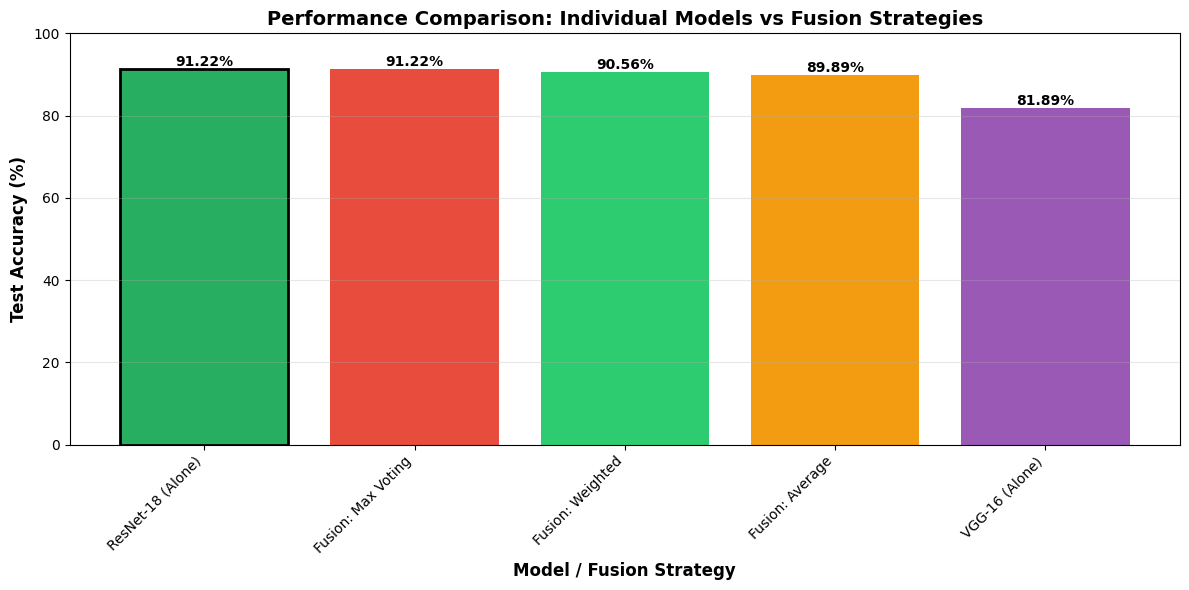

In [14]:
# Bar plot comparison
plt.figure(figsize=(12, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
bars = plt.bar(results_comparison['Model'], results_comparison['Test Accuracy (%)'], color=colors)

# Highlight the best model
bars[0].set_color('#27ae60')
bars[0].set_edgecolor('black')
bars[0].set_linewidth(2)

plt.xlabel('Model / Fusion Strategy', fontsize=12, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Performance Comparison: Individual Models vs Fusion Strategies', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(FUSION_PATH / 'fusion_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Confusion Matrix - Best Fusion Model

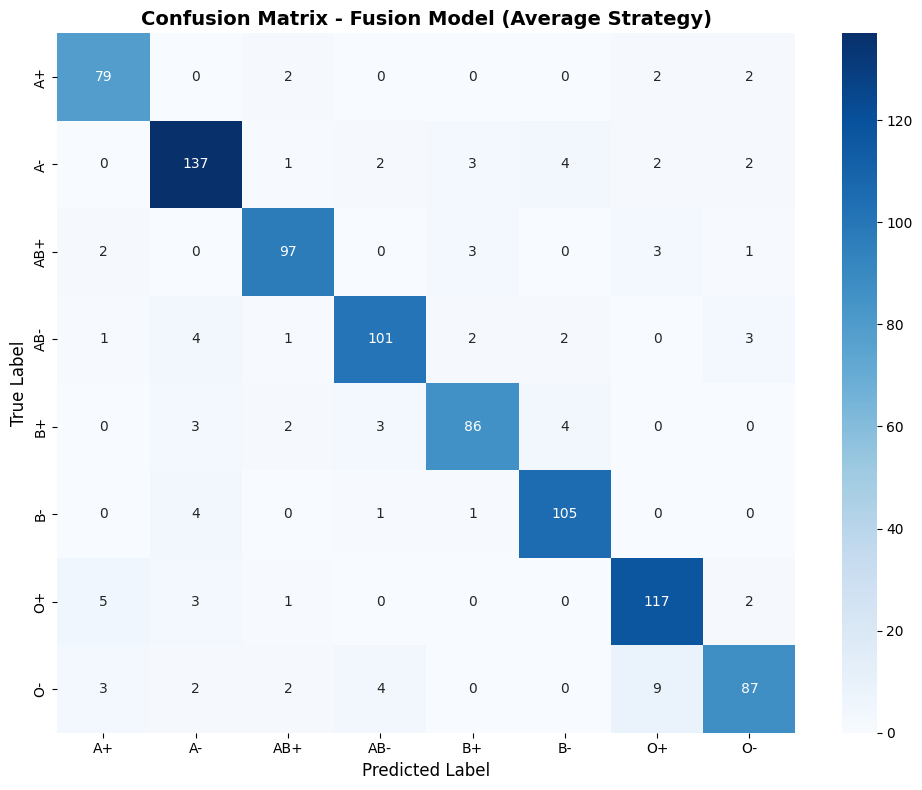

In [15]:
# Use the best fusion strategy (average by default)
cm = confusion_matrix(fusion_labels, fusion_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=BLOOD_GROUPS, yticklabels=BLOOD_GROUPS)
plt.title('Confusion Matrix - Fusion Model (Average Strategy)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(FUSION_PATH / 'confusion_matrix_fusion.png', dpi=300, bbox_inches='tight')
plt.show()

# Save confusion matrix
pd.DataFrame(cm, index=BLOOD_GROUPS, columns=BLOOD_GROUPS).to_csv(FUSION_PATH / 'confusion_matrix.csv')

## Save Final Results

In [16]:
# Save comparison table
results_comparison.to_csv(FUSION_PATH / 'model_comparison.csv', index=False)

# Save classification report for best fusion
report = classification_report(fusion_labels, fusion_preds, target_names=BLOOD_GROUPS, output_dict=True)
pd.DataFrame(report).transpose().to_csv(FUSION_PATH / 'classification_report_fusion.csv')

# Save final results JSON
final_results = {
    'fusion_model': 'ResNet-18 + VGG-16',
    'fusion_strategies': {
        'average': fusion_avg_acc * 100,
        'weighted': fusion_weighted_acc * 100,
        'max_voting': fusion_maxvote_acc * 100
    },
    'best_fusion_strategy': best_model['Model'],
    'best_fusion_accuracy': float(best_model['Test Accuracy (%)']),
    'individual_models': {
        'resnet18': model1_results['test_acc'],
        'vgg16': model2_results['test_acc']
    },
    'improvement': {
        'over_resnet18': float(best_model['Test Accuracy (%)']) - model1_results['test_acc'],
        'over_vgg16': float(best_model['Test Accuracy (%)']) - model2_results['test_acc']
    }
}

with open(FUSION_PATH / 'fusion_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("\n" + "="*60)
print("FUSION MODEL EVALUATION COMPLETE")
print("="*60)
print(f"\nAll results saved to: {FUSION_PATH}")
print("\nFiles saved:")
print("  - model_comparison.csv")
print("  - fusion_results.json")
print("  - classification_report_fusion.csv")
print("  - confusion_matrix.csv")
print("  - fusion_comparison.png")
print("  - confusion_matrix_fusion.png")
print("="*60)


FUSION MODEL EVALUATION COMPLETE

All results saved to: C:\Users\phoga\Desktop\HemoPrint\model_results\fusion_model

Files saved:
  - model_comparison.csv
  - fusion_results.json
  - classification_report_fusion.csv
  - confusion_matrix.csv
  - fusion_comparison.png
  - confusion_matrix_fusion.png
